In [1]:
# import required libraries

import os
import sys
import configparser

from PIL import Image
import collections

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap, BoundaryNorm

import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import RandomAffine

In [2]:
# set the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device)

Device is: cuda


In [3]:
# set the hyperparameters

config = configparser.ConfigParser()

config['CAE'] = {'rand_seed': 765, 'ks': 3, 'nf0': 15, 'nf1': 45, 'nf2': 128, 'nf3': 196, 'nf4': 128, 'nf5': 128, 'nf6': 128,
                 'nfc': 14}

config['IM'] = {'lambda_affine': 0.03, 'lambda_marginal_entropy': 0.1, 'lambda_conditional_entropy': 0.03,
                'learning_rate': 0.003}

config.write(sys.stdout)

[CAE]
rand_seed = 765
ks = 3
nf0 = 15
nf1 = 45
nf2 = 128
nf3 = 196
nf4 = 128
nf5 = 128
nf6 = 128
nfc = 14

[IM]
lambda_affine = 0.03
lambda_marginal_entropy = 0.1
lambda_conditional_entropy = 0.03
learning_rate = 0.003



In [4]:
rand_seed = int(config['CAE']['rand_seed'])
ks        = int(config['CAE']['ks'])
nf0       = int(config['CAE']['nf0'])
nf1       = int(config['CAE']['nf1'])
nf2       = int(config['CAE']['nf2'])
nf3       = int(config['CAE']['nf3'])
nf4       = int(config['CAE']['nf4'])
nf5       = int(config['CAE']['nf5'])
nf6       = int(config['CAE']['nf6'])
nfc       = int(config['CAE']['nfc'])

In [5]:
lambda_affine              = float(config['IM']['lambda_affine'])
lambda_marginal_entropy    = float(config['IM']['lambda_marginal_entropy'])
lambda_conditional_entropy = float(config['IM']['lambda_conditional_entropy'])
learning_rate              = float(config['IM']['learning_rate'])

In [6]:
# set random seed

print('random seed:', rand_seed)

torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
np.random.seed(rand_seed)

random seed: 765


In [7]:
# load the dataset

data_src = np.load('/home/is/mahfujul-r/Make/YT/seq_patches_18252_from_1wsi.npy') # location of the dataset
print(data_src.shape)

(18252, 5, 128, 128, 3)


In [8]:
# custom functions to extract batches of samples

def get_batch_index_tr(tr, batch_size=None, shuffle=True):
    if (shuffle):
        np.random.shuffle(tr)
    if (batch_size is not None):
        n_batch = len(tr) // batch_size
    batch_list = np.array_split(tr, n_batch)
    return batch_list

def get_batch_index_ae(ae, batch_size=None, shuffle=True):
    tr = np.arange(ae)
    batch_list = get_batch_index_tr(tr, batch_size=batch_size, shuffle=shuffle)
    return batch_list

In [9]:
ix, iy = 64, 64 # 128x128 patches are getting rescaled

#affine transformation
add_random_affine = RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=(161, 138, 172)) 

def generate_batch(iii, src, device, random_affine=False):
    if (random_affine):
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0])
            img_tmp0 = add_random_affine(img_tmp0).resize((ix, iy)) # HE
            img_tmp2 = Image.fromarray(src[ii, 2])
            img_tmp2 = add_random_affine(img_tmp4).resize((ix, iy)) # CD31
            img_tmp3 = Image.fromarray(src[ii, 3])
            img_tmp3 = add_random_affine(img_tmp5).resize((ix, iy)) # CK19
            img_tmp4 = Image.fromarray(src[ii, 4])
            img_tmp4 = add_random_affine(img_tmp6).resize((ix, iy)) # Ki67
            img_tmp1 = Image.fromarray(src[ii, 1])
            img_tmp1 = add_random_affine(img_tmp7).resize((ix, iy)) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp2, img_tmp3, img_tmp4, img_tmp1), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    else:
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0]).resize((ix, iy)) # HE
            img_tmp2 = Image.fromarray(src[ii, 2]).resize((ix, iy)) # CD31
            img_tmp3 = Image.fromarray(src[ii, 3]).resize((ix, iy)) # CK19
            img_tmp4 = Image.fromarray(src[ii, 4]).resize((ix, iy)) # Ki67
            img_tmp1 = Image.fromarray(src[ii, 1]).resize((ix, iy)) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp2, img_tmp3, img_tmp4, img_tmp1), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    return (xxx.to(device))

`CAE` (Convolutional AutoEncoder) architecture

- `Encoder` class

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(in_channels=nf0, out_channels=nf1, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor1', nn.BatchNorm2d(num_features=nf1, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel1', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv2', nn.Conv2d(in_channels=nf1, out_channels=nf2, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor2', nn.BatchNorm2d(num_features=nf2, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv3', nn.Conv2d(in_channels=nf2, out_channels=nf3, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor3', nn.BatchNorm2d(num_features=nf3, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv4', nn.Conv2d(in_channels=nf3, out_channels=nf4, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor4', nn.BatchNorm2d(num_features=nf4, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel4', nn.LeakyReLU(0.1, inplace=True))
        
    def forward(self, xxx):
        hhh = self.encoder(xxx)        
        return hhh

- `Classifier` class

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential()
        self.classifier.add_module('conv1', nn.Conv2d(in_channels=nf4, out_channels=nf5, kernel_size=4, stride=1, padding=0))
        self.classifier.add_module('bnor1', nn.BatchNorm2d(num_features=nf5, affine=True, track_running_stats=True))
        self.classifier.add_module('lrel1', nn.LeakyReLU(0.1, inplace=True))
        self.classifier.add_module('conv2', nn.Conv2d(in_channels=nf5, out_channels=nf6, kernel_size=1, stride=1, padding=0))
        self.classifier.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.classifier.add_module('conv3', nn.Conv2d(in_channels=nf6, out_channels=nfc, kernel_size=1, stride=1, padding=0))
        self.classifier.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        
    def forward(self, hhh):
        vvv = self.classifier(hhh)
        return vvv

- `Decoder` class

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('upsm4', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov4', nn.Conv2d(in_channels=nf4 + nfc, out_channels=nf3, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm4', nn.BatchNorm2d(num_features=nf3, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel4', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm3', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov3', nn.Conv2d(in_channels=nf3, out_channels=nf2, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm3', nn.BatchNorm2d(num_features=nf2, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm2', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov2', nn.Conv2d(in_channels=nf2, out_channels=nf1, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm2', nn.BatchNorm2d(num_features=nf1, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm1', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov1', nn.Conv2d(in_channels=nf1, out_channels=nf0, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm1', nn.BatchNorm2d(num_features=nf0, affine=True, track_running_stats=True))
        self.decoder.add_module('sgmd1', nn.Sigmoid())
        
    def forward(self, hhh, vvv):
        ccc = vvv.repeat((1, 1, ix//16, iy//16))
        hhh = torch.cat((hhh, ccc), dim=1)
        yyy = self.decoder(hhh)
        return yyy

In [13]:
model_en = Encoder().to(device)
model_cl = Classifier().to(device)
model_de = Decoder().to(device)

# load models
model_en.load_state_dict(torch.load('./128/models14/model_en_202211280036_4000.ckpt'))
model_cl.load_state_dict(torch.load('./128/models14/model_cl_202211280036_4000.ckpt'))
model_de.load_state_dict(torch.load('./128/models14/model_de_202211280036_4000.ckpt'))

<All keys matched successfully>

In [14]:
# prepare to detect cluster IDs

iii_batch = get_batch_index_ae(18252, batch_size=100, shuffle=False) # first 15000 samples

vvv_list = []

with torch.inference_mode():
    for iii in iii_batch:
        xxx_tmp = generate_batch(iii, data_src, device)
        
        model_en.eval()
        model_cl.eval()
        
        hhh_tmp = model_en(xxx_tmp)
        vvv_tmp = model_cl(hhh_tmp)
        
        vvv_list.append(torch.softmax(vvv_tmp.reshape((-1, nfc)), dim=1).detach().cpu().numpy())
        
    vvv_18k = np.concatenate(vvv_list, axis=0)
    print('Embedded features in lower latent space:', vvv_18k.shape)

Embedded features in lower latent space: (18252, 14)


In [15]:
C = []

for j in range(len(vvv_18k)):
    hemp1 = vvv_18k[j, :]
    hemp2 = np.argmax(hemp1) # collect cluster IDs with highest probability for each patch
    C.append(hemp2)

In [16]:
C_plus_1 = np.array(C) + 1 # to avoid 0-indexing confusion in cluster labels

In [17]:
show = collections.Counter(C_plus_1)
show

Counter({3: 12127,
         6: 437,
         10: 404,
         9: 1359,
         12: 935,
         2: 857,
         8: 199,
         5: 462,
         4: 379,
         14: 231,
         13: 259,
         1: 309,
         11: 154,
         7: 140})

In [18]:
np.unique(C_plus_1) # clusters labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

plot `histogram`

In [19]:
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # cluster labels

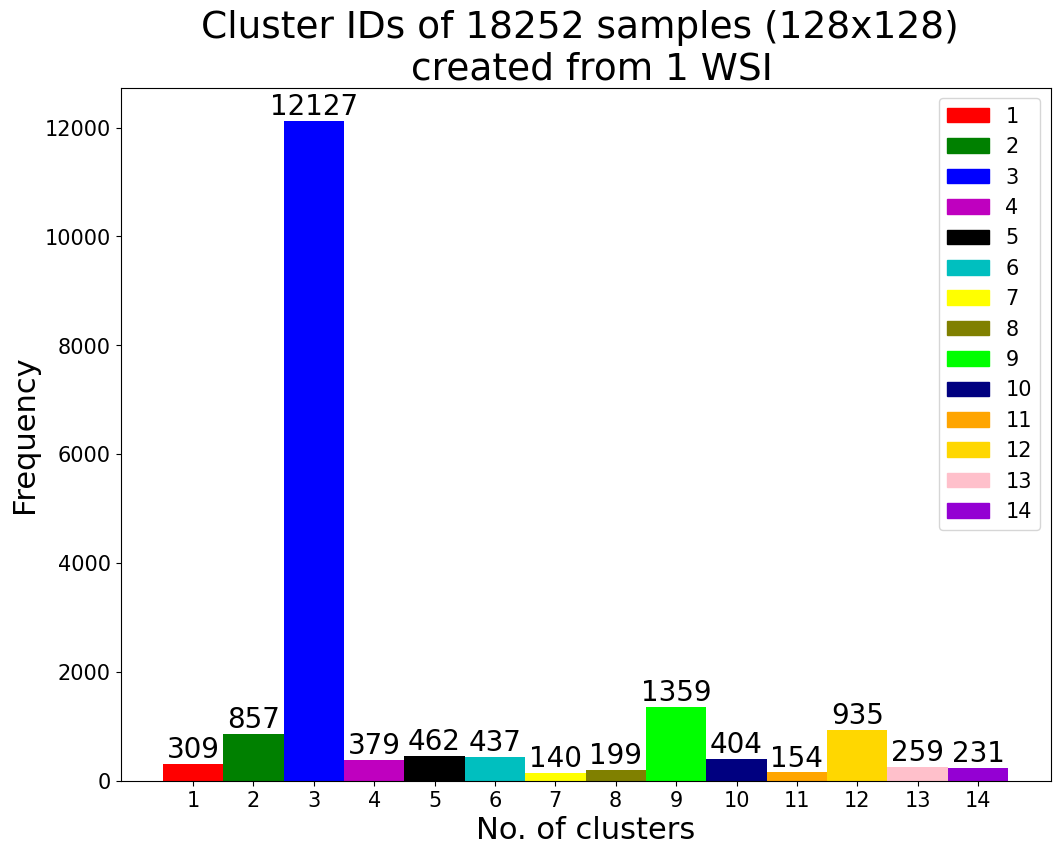

In [20]:
plt.figure(figsize=(12, 9))

colors = ['r', 'g', 'b', 'm', 'k', 'c', 'yellow', 'olive', 'lime', 'navy', 'orange', 'gold', 'pink', 'darkviolet']
_, _, patches = plt.hist(C_plus_1, bins=range(1, 16), align='left')

for c, p in zip(colors, patches):
    p.set_facecolor(c)

handles = [Rectangle((0, 0), 1, 1, color=c) for c in colors]

plt.legend(handles, labels, fontsize=15)
plt.xlabel('No. of clusters', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.title('Cluster IDs of 18252 samples (128x128) \n created from 1 WSI', fontsize=27)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], fontsize=15)
plt.yticks(fontsize=15)
plt.bar_label(patches, fontsize=20);

plot `colormap`

In [21]:
arr = np.array(C_plus_1)
reshaped = np.reshape(arr, (117, 156)) # reshape to plot colormap

In [22]:
np.unique(reshaped) # matches with unique cluster labels of 'C_plus_1'

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

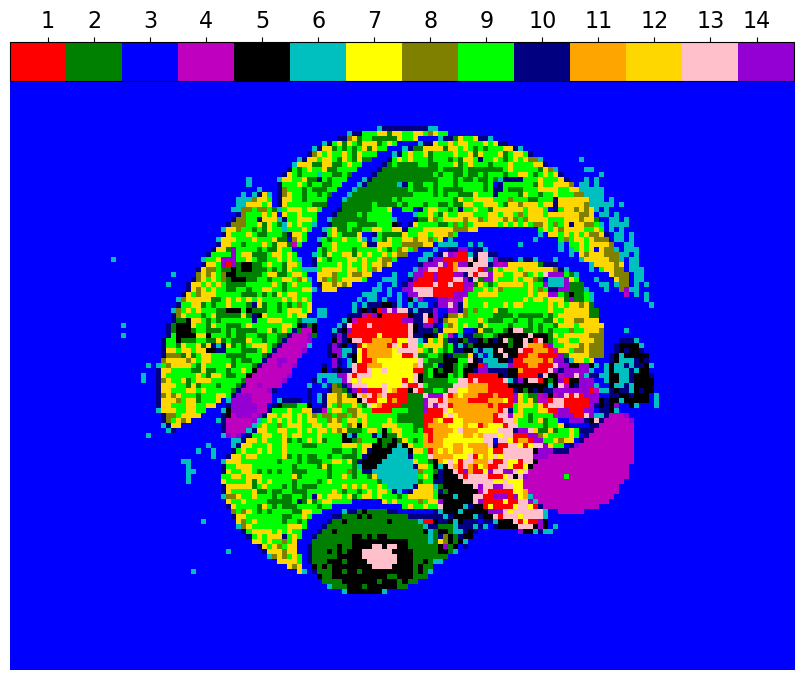

In [23]:
plt.figure(figsize=(12, 9))

cols = ['r', 'g', 'b', 'm', 'k', 'c', 'yellow', 'olive', 'lime', 'navy', 'orange', 'gold', 'pink', 'darkviolet']
u = np.unique(reshaped)
bounds = np.concatenate(([reshaped.min()-1], u[:-1] + np.diff(u) / 2, [reshaped.max()+1]))

cmap = ListedColormap(cols)
norm = BoundaryNorm(bounds, len(bounds)-1)

plt.imshow(reshaped, interpolation='nearest', cmap=cmap, norm=norm)
cbar = plt.colorbar(orientation='horizontal', shrink=0.843, location='top', pad=0.001)
cbar.set_ticks(labels)
cbar.ax.tick_params(labelsize=16)
plt.axis(False);